# Описание проекта

Необходимо проанализировать работу развлекательного приложения Procrastinate Pro+.
Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. 

Задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:

- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Необходимо изучить:

- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

In [1]:
import pandas as pd # импорт библиотеки pandas
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from datetime import datetime, timedelta

In [2]:
# загрузка файлов для работы исходя из места запуска (локально или на сервере)
import os

pth1 = 'C:/Users/User/Desktop/Python/Jupyter/visits_info_short.csv'
pth2 = '/datasets/visits_info_short.csv'

if os.path.exists(pth1):
    visits  = pd.read_csv(pth1)
elif os.path.exists(pth2):
    visits  = pd.read_csv(pth2)
else:
    print('Something is wrong with visits')
    
pth3 = 'C:/Users/User/Desktop/Python/Jupyter/orders_info_short.csv'
pth4 = '/datasets/orders_info_short.csv'

if os.path.exists(pth3):
    orders  = pd.read_csv(pth3)
elif os.path.exists(pth4):
    orders  = pd.read_csv(pth4)
else:
    print('Something is wrong with orders')
    
pth5 = 'C:/Users/User/Desktop/Python/Jupyter/costs_info_short.csv'
pth6 = '/datasets/costs_info_short.csv'

if os.path.exists(pth5):
    costs  = pd.read_csv(pth5)
elif os.path.exists(pth6):
    costs  = pd.read_csv(pth6)
else:
    print('Something is wrong with costs')

Посмотрим сводную информацию по файлам, заменим тип данных на дату в колонках, где указаны даты. Проверим на дубликаты.

# Подготовка данных для анализа

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns]
visits.head()

user_id         region   device  channel        session_start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           session_end  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

In [5]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [6]:
visits.duplicated().sum()

0

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [8]:
orders.rename(columns={'User Id': 'user_id',
                       'Event Dt': 'event_dt',
                      'Revenue' : 'revenue'}, inplace=True)
orders.head()

user_id             event_dt  revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [9]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [10]:
orders.duplicated().sum()

0

In [11]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [12]:
costs.rename(columns={'Channel': 'channel'}, inplace=True)
costs.head()

dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [13]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [14]:
costs.duplicated().sum()

0

В таблицах заменили тип данных на дату, где указаны даты. Заменили названия столбцов с учетом общепринятых правил. Дубликатов в таблицах нет, пропусков тоже. 
Далее для анализа напишем функции для расчета и анализа LTV, ROI, удержания и конверсии.

# Подготовка функций для анализа

In [15]:
# функция для создания пользовательских профилей

def get_profiles(visits, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [16]:
# функция для расчёта удержания

def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [17]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [18]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [19]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [20]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [21]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=1):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [22]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

# Исследовательский анализ данных

## Создание пользовательских профилей

Создадим профили и определиим минимальную и максимальную даты привлечения пользователей.

In [23]:
pd.set_option('display.float_format', '{:.2f}'.format)
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
display (profiles.head()) 

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True              1.09  
1  2019-07-09 2019-07-01  False              1.11  
2  2019-10-01 2019-10-01  False              0.00  
3  2019-08-22 2019-08-01  False              0.99  
4  2019-10-02 2019-10-01  False              0.23

In [24]:
display (profiles['first_ts'].min())
display (profiles['first_ts'].max())

Timestamp('2019-05-01 00:00:41')

Timestamp('2019-10-27 23:59:04')

Мы располагаем данными с 1 мая 2019 по 27 октября 2019, соответственно самая ранняя дата привлечения клиентов это 1 мая, а самая поздняя это 27 октября.

Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [25]:
display(profiles.groupby('region').agg({'user_id': 'nunique', 'payer' : 'mean'}).sort_values(by='payer', ascending=False)) 

user_id  payer
region                       
United States   100002   0.07
Germany          14981   0.04
UK               17575   0.04
France           17450   0.04

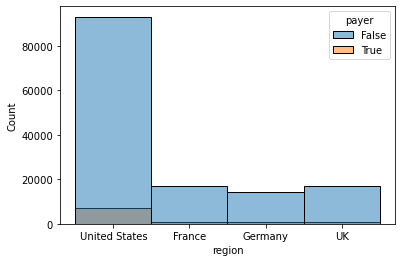

In [26]:
sns.histplot(x="region", data=profiles , hue="payer")
plt.show()

Больше всего пользователей из США и там же выше всего доля платящих пользователей - 7%, а в остальных она примерно одинаковая - около 4%.

Посмотрим какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 
Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [27]:
display (profiles.groupby('device').agg({'user_id': 'nunique', 'payer' : 'mean'}).sort_values(by='payer', ascending=False))

user_id  payer
device                 
Mac        30042   0.06
iPhone     54479   0.06
Android    35032   0.06
PC         30455   0.05

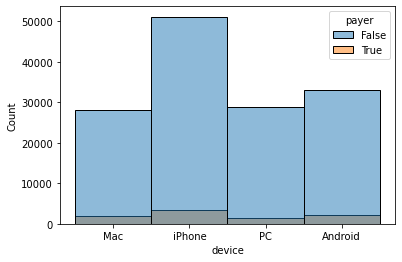

In [28]:
sns.histplot(x="device", data=profiles , hue="payer")
plt.show()

Пользователи пользуются: Mac, iPhone, Android, PC. Больше всего пользователи используют IPhone, а доля платящих больше всего у Mac, но IPhone и Android отстают на несколько сотых %, а PC на 1 %.

Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. 
Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [29]:
display (profiles.groupby('channel').agg({'user_id': 'nunique', 'payer' : 'mean'}).sort_values(by='payer', ascending=False))

user_id  payer
channel                           
FaceBoom              29144   0.12
AdNonSense             3880   0.11
lambdaMediaAds         2149   0.10
TipTop                19561   0.10
RocketSuperAds         4448   0.08
WahooNetBanner         8553   0.05
YRabbit                4312   0.04
MediaTornado           4364   0.04
LeapBob                8553   0.03
OppleCreativeMedia     8605   0.03
organic               56439   0.02

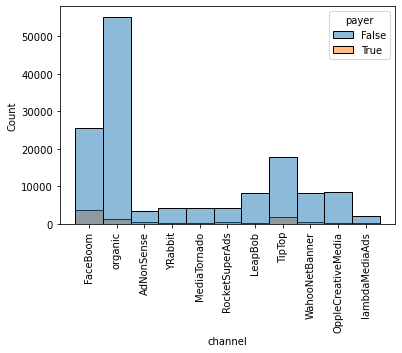

In [30]:
sns.histplot(x="channel", data=profiles , hue="payer")
plt.xticks(rotation=90)
plt.show()

Больше всего платящих пользователей пришло из канала FaceBoom, а меньше всего именно платящищих пришло из канала organic, но при этом из этого же канала пришло в олбщем самое большое количество пользователей, а на втором месте FaceBoom.

Итак, мы выяснили:
1. Что располагаем данными с 1 мая 2019 по 27 октября 2019, соответственно самая ранняя дата привлечения клиентов это 1 мая, а самая поздняя это 27 октября.
2. Больше всего пользователей из США и там же выше всего доля платящих пользователей - 7%, а в остальных она примерно одинаковая - около 4%.
3. Пользователи пользуются: Mac, iPhone, Android, PC. Больше всего пользователи используют IPhone, а доля платящих больше всего у Mac, но IPhone и Android отстают на несколько сотых %, а PC на 1 %.
4. Больше всего платящих пользователей пришло из канала FaceBoom, а меньше всего именно платящищих пришло из канала organic, но при этом из этого же канала пришло в олбщем самое большое количество пользователей, а на втором месте FaceBoom.

# Анализ маркетинговых данных

Посчитаем общую сумму расходов на маркетинг. Выясниим, как траты распределены по источникам. 
Визуализируем изменения метрик во времени.

In [31]:
display (costs['costs'].sum().round(0))

105497.0

In [32]:
display (costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False))

costs
channel                    
TipTop             54751.30
FaceBoom           32445.60
WahooNetBanner      5151.00
AdNonSense          3911.25
OppleCreativeMedia  2151.25
RocketSuperAds      1833.00
LeapBob             1797.60
lambdaMediaAds      1557.60
MediaTornado         954.48
YRabbit              944.22

Общая сумма расходов на маркетинг составляет 105497. Самые дорогие 2 источника это TipTop и FaceBoom.

In [33]:
fig = px.line(
    costs,
    x='dt',
    y='costs',
    color='channel',
    title='Динамика вложение в рекламу в разбивке по каналам',
)
fig.update_xaxes(tickangle=45)
fig.show() 

По графику динамики вложений, видно, что в канал TipTop вложения ежемесячно растут (в основном в конце или начале месяца), при чем в TipTop вложения растут значительно (в 3 раза за период). В FaceBoom вложения начиная с июня выше чем в остальные каналы, но стабильно около 250. В мае были вложения в AdNonSense выше чем в остальной период. По остальным каналам на протяжении всего периода вложения низкие и стабильные.

Теперь узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника. Для этого рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика. 

In [34]:
profiles['acquisition_cost'].mean()

0.7032778251827625

In [35]:
display (profiles.groupby('channel').agg({'acquisition_cost': 'mean'}).sort_values(by='acquisition_cost', ascending=False))

acquisition_cost
channel                             
TipTop                          2.80
FaceBoom                        1.11
AdNonSense                      1.01
lambdaMediaAds                  0.72
WahooNetBanner                  0.60
RocketSuperAds                  0.41
OppleCreativeMedia              0.25
YRabbit                         0.22
MediaTornado                    0.22
LeapBob                         0.21
organic                         0.00

Средний САС на одного пользователя в общем равен 0,7. Выше таблица со средним САС по каналам. Самый дорогой канал Tip Top, самый дешевый LeapBob, а канал organic это пользователи которые пришли сами без рекламы.

В итоге, в канал TipTop вложения ежемесячно растут (в основном в конце или начале месяца), при чем в TipTop вложения растут значительно (в 3 раза за период). В FaceBoom вложения начиная с июня выше чем в остальные каналы, но стабильно около 250. В мае были вложения в AdNonSense выше чем в остальной период. По остальным каналам на протяжении всего периода вложения низкие и стабильные. Средний САС на одного пользователя в общем равен 0,7. Выше таблица со средним САС по каналам. Самый дорогой канал Tip Top, самый дешевый LeapBob, а канал organic это пользователи которые пришли сами без рекламы.

# Оценка окупаемости рекламы

Сегодня на календаре 1 ноября 2019 года, в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Это значит, что для оценки можно использовать пользователей пришедших не менее 14 дней назад.

Также известно, что есть канал рекламы organic, а это клиенты которые пришли сами, т.е. на них не тратились, и чтобы не искажать результаты, удалим этот канал из анализа.

Проанализируем общую окупаемость рекламы. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [36]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 
profiles = profiles.query('channel != "organic"')

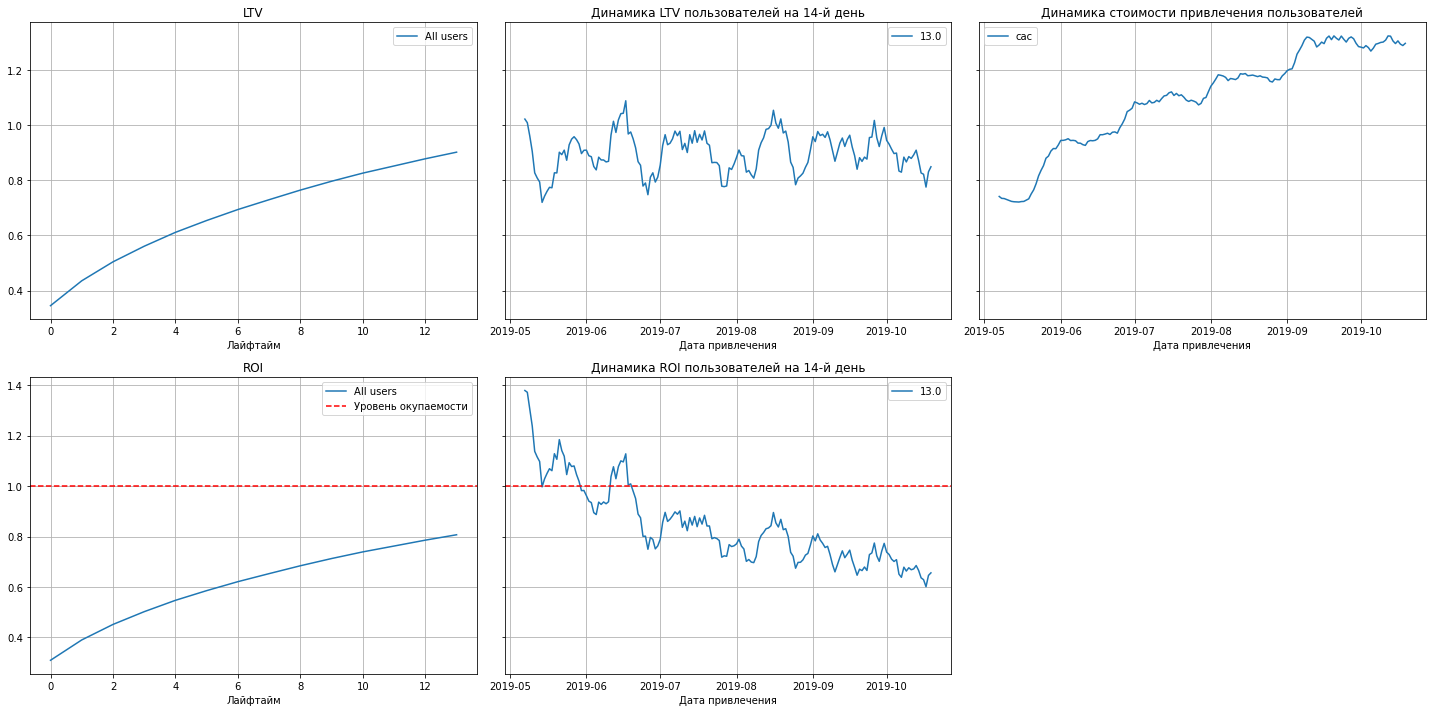

In [37]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Ценность клиента растет (LTV). ROI к 14 окупается лишь на 80%. САС растет, соответвенно рекламный бюджет растет. Динамика LTV находится примерно в одном диапазоне от 0,8 до 1. Клиенты привлеченные в мае и несколько в июне окупились на 14й день, а клиенты привлеченные в остальные месяца не окупились на 14 день.

Чтобы разобраться в причинах, пройдём по характеристикам пользователей — стране и каналу рекламы.

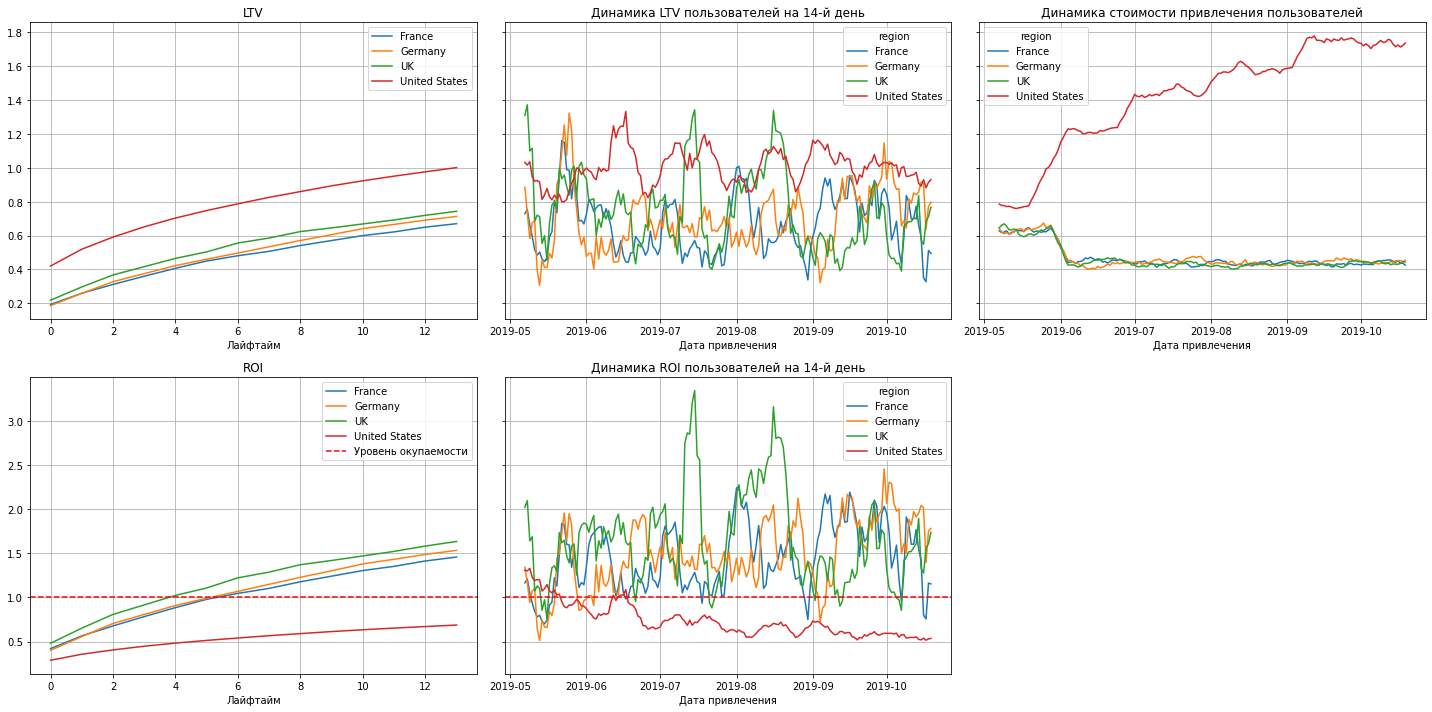

In [38]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

LTV выше в США, чем в остальных странах. Начиная с 4 дня жизни, клиенты из всех стран, кроме США окупаются. На 14й день клиенты привлеченные в мае и июне из США незначительно окупаются, а после июня клиенты не окупаются. По остальным странам клиенты окупаются (исключение май), пики приходятся на летние месяца (июль, август). А вот стоимость привлечения пользователей для клиентов из США резко растет с июня, а по остальным странам падает.

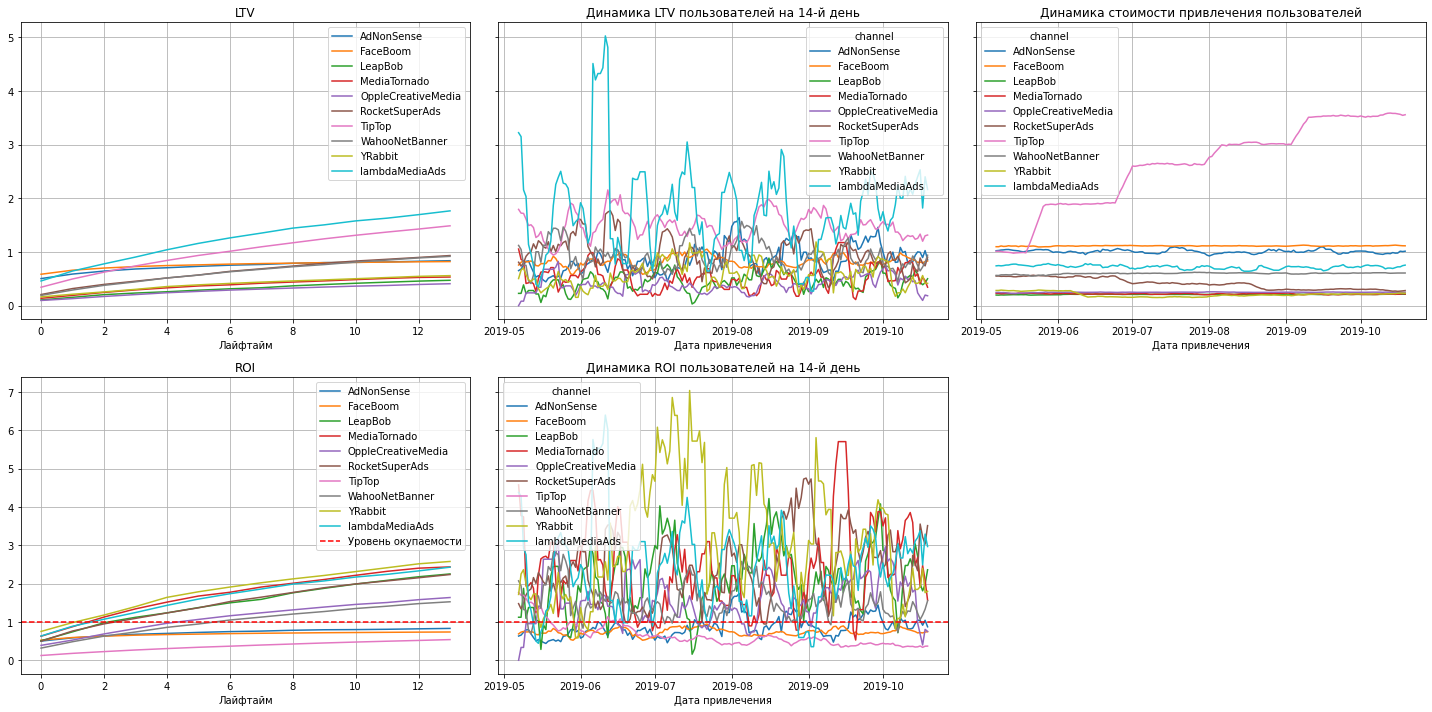

In [39]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Самую высокую ценность приносят клиенты пришедшие из каналов LambdaMediaAds и Tip Top, при этом на 14й день большую ценность приносит канал LambdaMediaAds. Самая дорогая реклама в канале Tip Top, и она же меньше всех окупается. На 14 день не окупаются клиенты из каналов: Tip Top, FaceBoom, AdNonSense, аналогично с динамикой окупаемости. Лучше всех окупаются клиенты из канала YRabbit.

В итоге, реклама не окупается. В основном за счет клиентов из США пришедших после июля и рекламы в канале Tip Top,  FaceBoom, AdNonSense.

Посмотрим на графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

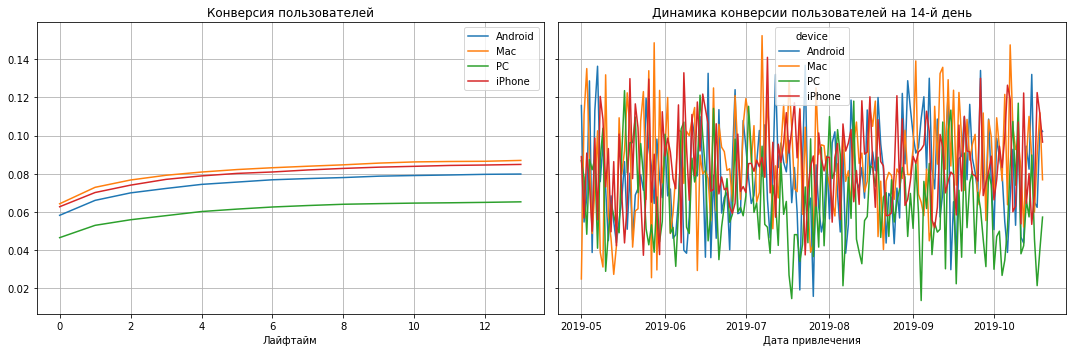

In [40]:
# смотрим конверсию с разбивкой по устройствам
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по конверсии в разбивки по устройствам с устройством - РС приходит мало клиентов.

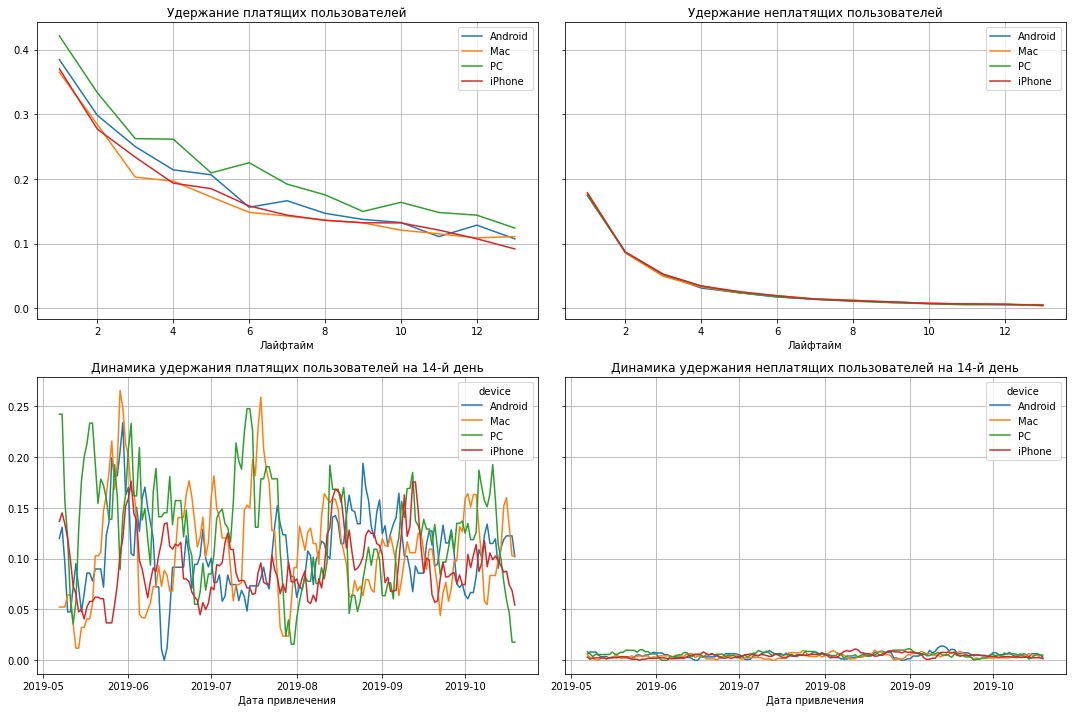

In [41]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание к 14 дню падает по всем устройствам для платящих пользователей. В общем удерживаются лучше PC, но клиенты привлеченные в августе и далее удерживаются хуже, чем более ранние.

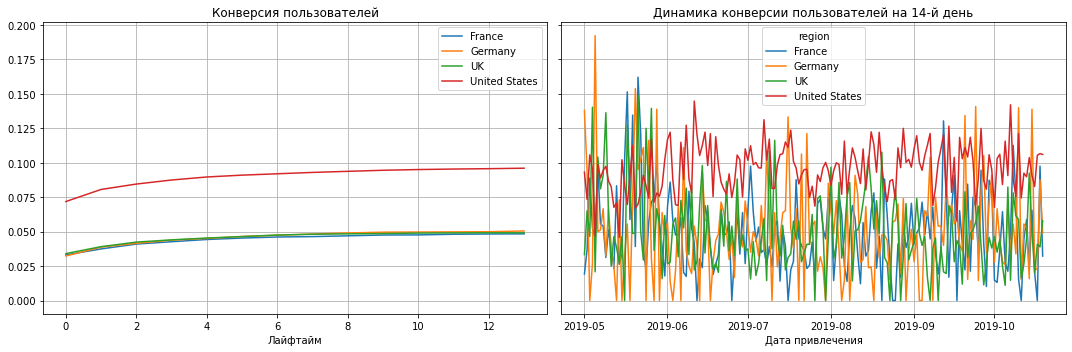

In [42]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Лучше всех конвертируются пользователи из США. Динамика стабильна.

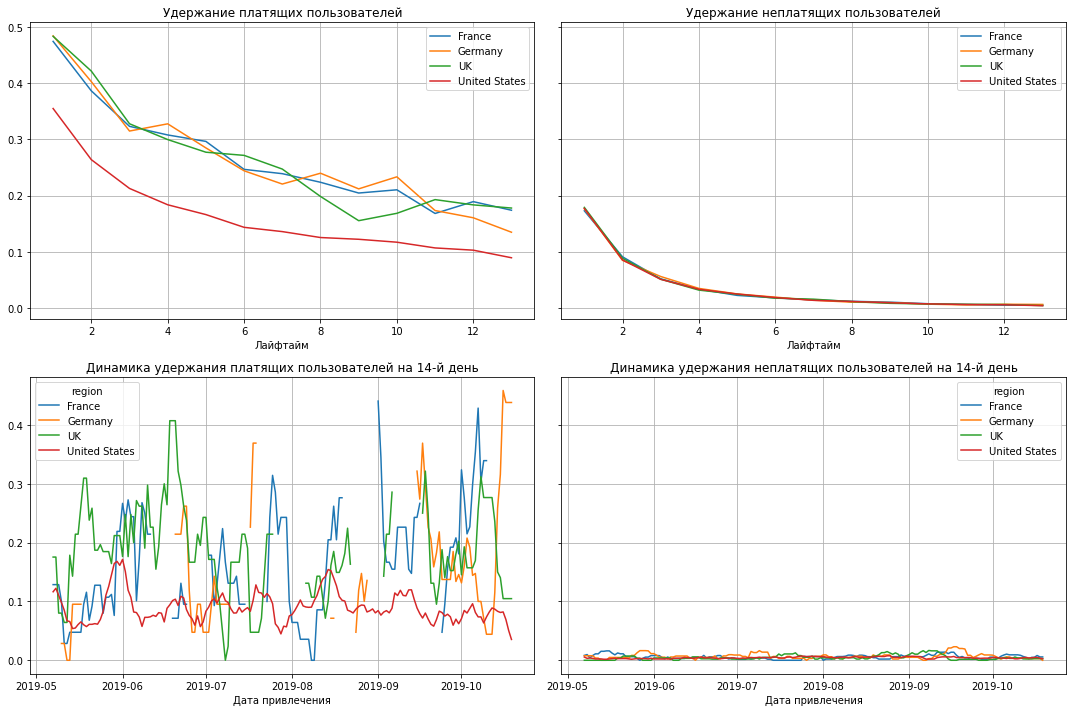

In [43]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Хуже всех удерживаются платящие пользователи из США.

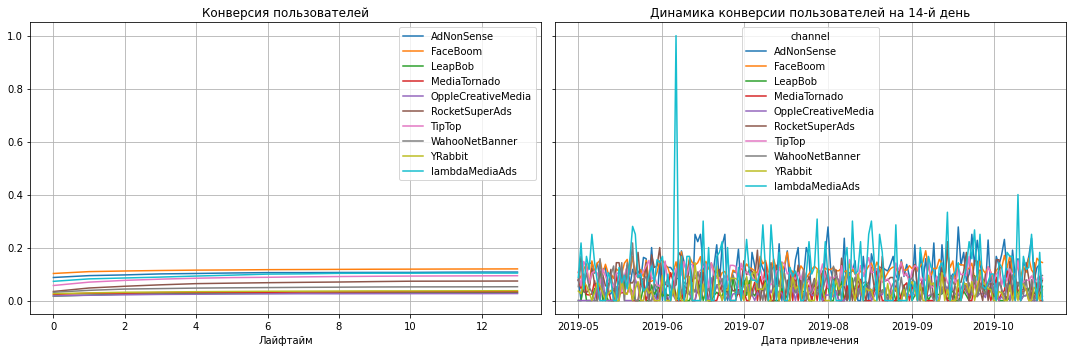

In [44]:
# смотрим конверсию с разбивкой по каналам рекламы
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия по каналам стабильна низкая. Единственное на 14й день клиенты пришедшие в начале июня из канала LambdaMediaAds конвертировались очень высоко.

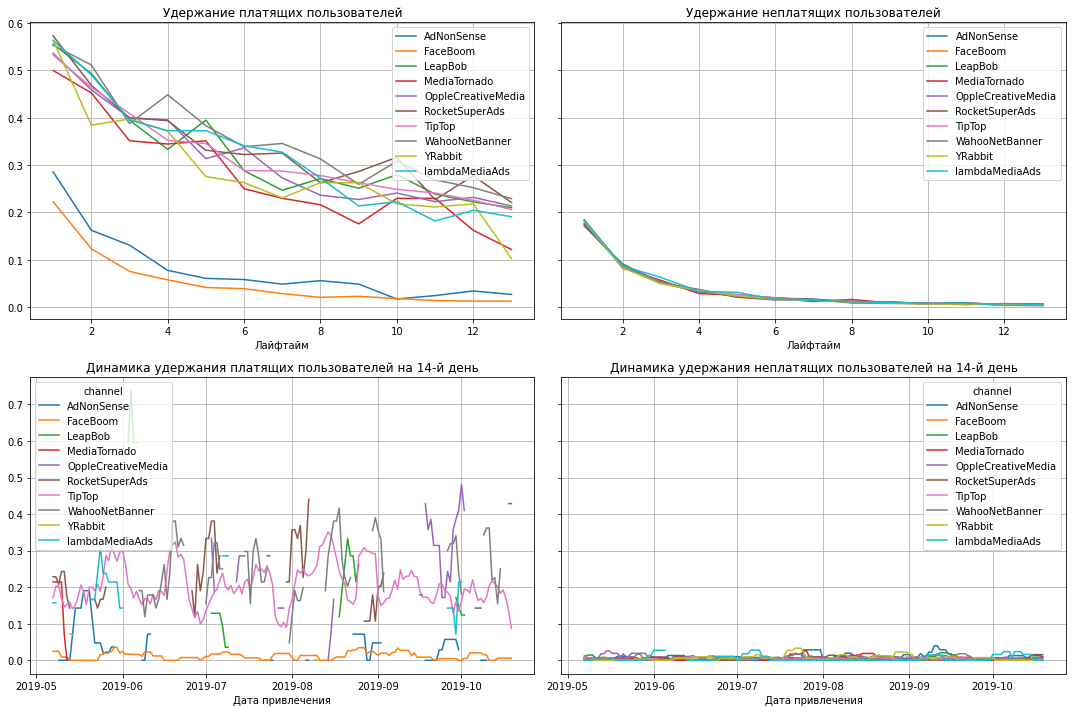

In [45]:
# смотрим удержание с разбивкой по каналам рекламы

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Хуже всего удерживаются платящие клиенты из каналов FaceBoom и AdNonSense. На 14й день хуже всех удерживаются клиенты из канала FaceBoom.

Проанализировав данные можно сделать следующие выводы:

1. В общем реклама не окупается. 

2. Самая дорогая реклама в США. Самые дорогие каналы рекламы это Tip Top и FaceBoom.

3. С июля вложения в рекламу в США в каналы Tip Top и FaceBoom стали слишком большие и перестали окупаться, при этом как раз клиенты из канала  FaceBoom удерживаются хуже всего.

Вероятно проблема с рекламой в канале FaceBoom, т.к. она одна из самых дорогих, но не эффективных. Возможно реклама перестала быть легко доступной для клиентов, т.к. в течении всего периода стоимость реклаым не менялась, она была стабильно высокой. И Из этого канала пришло больше всего платящих пользователей.


# Выводы

Итак, мы располагаем данными с 1 мая 2019 по 27 октября 2019, соответственно самая ранняя дата привлечения клиентов это 1 мая, а самая поздняя это 27 октября.

Больше всего пользователей из США и там же выше всего доля платящих пользователей - 7%, а в остальных она примерно одинаковая - около 4%.

Пользователи пользуются: Mac, iPhone, Android, PC. Больше всего пользователи используют IPhone, а доля платящих больше всего у Mac, но IPhone и Android отстают на несколько сотых %, а PC на 1 %.

Больше всего платящих пользователей пришло из канала FaceBoom, а меньше всего именно платящищих пришло из канала organic, но при этом из этого же канала пришло в общем самое большое количество пользователей, а на втором месте FaceBoom.

Общая сумма расходов на маркетинг составляет 105497. Самые дорогие 2 источника это TipTop и FaceBoom.
По графику динамики вложений, видно, что в канал TipTop вложения ежемесячно растут (в основном в конце или начале месяца), при чем в TipTop вложения растут значительно (в 3 раза за период). В FaceBoom вложения начиная с июня выше чем в остальные каналы, но стабильно около 250. В мае были вложения в AdNonSense выше чем в остальной период. По остальным каналам на протяжении всего периода вложения низкие и стабильные.

Средний САС на одного пользователя в общем равен 0,7. Самый дорогой канал Tip Top, самый дешевый LeapBob, а канал organic это пользователи которые пришли сами, без рекламы.

Ценность клиента растет (LTV). ROI к 14 окупается лишь на 80%. САС растет, соответвенно рекламный бюджет растет. Динамика LTV находится примерно в одном диапазоне от 0,8 до 1. Клиенты привлеченные в мае и несколько в июне окупились на 14й день, а клиенты привлеченные в остальные месяца не окупились на 14 день.

LTV выше в США, чем в остальных странах. Начиная с 4 дня жизни, клиенты из всех стран, кроме США окупаются. На 14й день клиенты привлеченные в мае и июне из США незначительно окупаются, а после июня клиенты не окупаются. По остальным странам клиенты окупаются (исключение май), пики приходятся на летние месяца (июль, август). А вот стоимость привлечения пользователей для клиентов из США резко растет с июня, а по остальным странам падает.

Самую высокую ценность приносят клиенты пришедшие из каналов LambdaMediaAds и Tip Top, при этом на 14й день большую ценность приносит канал LambdaMediaAds. Самая дорогая реклама в канале Tip Top, и она же меньше всех окупается. На 14 день не окупаются клиенты из каналов: Tip Top, FaceBoom, AdNonSense, аналогично с динамикой окупаемости. Лучше всех окупаются клиенты из канала YRabbit.

Судя по конверсии в разбивки по устройствам с устройством - РС приходит мало клиентов.


Удержание к 14 дню падает по всем устройствам для платящих пользователей. В общем удерживаются лучше PC, но клиенты привлеченные в августе и далее удерживаются хуже, чем более ранние.

Лучше всех конвертируются пользователи из США. Динамика стабильна.

Хуже всех удерживаются платящие пользователи из США.

Конверсия по каналам стабильна низкая. Единственное на 14й день клиенты пришедшие в начале июня из канала LambdaMediaAds конвертировались очень высоко. 
Хуже всего удерживаются платящие клиенты из каналов FaceBoom и AdNonSense. На 14й день хуже всех удерживаются клиенты из канала FaceBoom.

Рекомендации для отдела маркетинга:

1. Проверить рекламу в канале FaceBoom с июня, возможно она стала недоступна клиентам из США.
2. Сделать новую рекламу для клиентов из США, чтобы их удержать.
3. Пересмотреть рекламную кампанию в канале Tip Top.
